The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.5
!pip install -U mxnet-cu101==1.7.0


# The Image Classification Dataset
:label:`sec_fashion_mnist`

(~~The MNIST dataset is one of the widely used dataset for image classification, while it's too simple as a benchmark dataset. We will use the similar, but more complex Fashion-MNIST dataset~~)

One of the widely used dataset for image classification is the  MNIST dataset :cite:`LeCun.Bottou.Bengio.ea.1998`.
While it had a good run as a benchmark dataset,
even simple models by today's standards achieve classification accuracy over 95%,
making it unsuitable for distinguishing between stronger models and weaker ones.
Today, MNIST serves as more of sanity checks than as a benchmark.
To up the ante just a bit, we will focus our discussion in the coming sections
on the qualitatively similar, but comparatively complex Fashion-MNIST
dataset :cite:`Xiao.Rasul.Vollgraf.2017`, which was released in 2017.


In [1]:
%matplotlib inline
import sys
from mxnet import gluon
from d2l import mxnet as d2l

d2l.use_svg_display()

## Reading the Dataset

We can [**download and read the Fashion-MNIST dataset into memory via the build-in functions in the framework.**]


In [2]:
mnist_train = gluon.data.vision.FashionMNIST(train=True)
mnist_test = gluon.data.vision.FashionMNIST(train=False)

Fashion-MNIST consists of images from 10 categories, each represented
by 6000 images in the training dataset and by 1000 in the test dataset.
A *test dataset* (or *test set*) is used for evaluating  model performance and not for training.
Consequently the training set and the test set
contain 60000 and 10000 images, respectively.


In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

The height and width of each input image are both 28 pixels.
Note that the dataset consists of grayscale images, whose number of channels is 1.
For brevity, throughout this book
we store the shape of any image with height $h$ width $w$ pixels as $h \times w$ or ($h$, $w$).


In [4]:
mnist_train[0][0].shape

(28, 28, 1)

[~~Two utility functions to visualize the dataset~~]

The images in Fashion-MNIST are associated with the following categories:
t-shirt, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot.
The following function converts between numeric label indices and their names in text.


In [5]:
def get_fashion_mnist_labels(labels):  #@save
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

We can now create a function to visualize these examples.


In [6]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

Here are [**the images and their corresponding labels**] (in text)
for the first few examples in the training dataset.


(18, 28, 28, 1)


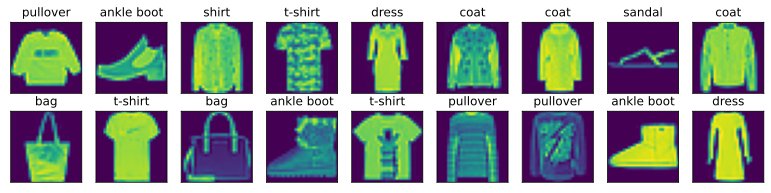

In [7]:
X, y = mnist_train[:18]

print(X.shape)
show_images(X.squeeze(axis=-1), 2, 9, titles=get_fashion_mnist_labels(y));

## Reading a Minibatch

To make our life easier when reading from the training and test sets,
we use the built-in data iterator rather than creating one from scratch.
Recall that at each iteration, a data iterator
[**reads a minibatch of data with size `batch_size` each time.**]
We also randomly shuffle the examples for the training data iterator.


In [8]:
batch_size = 256

def get_dataloader_workers():  #@save
    """Use 4 processes to read the data except for Windows."""
    return 0 if sys.platform.startswith('win') else 4

# `ToTensor` converts the image data from uint8 to 32-bit floating point. It
# divides all numbers by 255 so that all pixel values are between 0 and 1
transformer = gluon.data.vision.transforms.ToTensor()
train_iter = gluon.data.DataLoader(mnist_train.transform_first(transformer),
                                   batch_size, shuffle=True,
                                   num_workers=get_dataloader_workers())

Let us look at the time it takes to read the training data.


In [9]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'2.08 sec'

## Putting All Things Together

Now we define [**the `load_data_fashion_mnist` function
that obtains and reads the Fashion-MNIST dataset.**]
It returns the data iterators for both the training set and validation set.
In addition, it accepts an optional argument to resize images to another shape.


In [10]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """Download the Fashion-MNIST dataset and then load it into memory."""
    dataset = gluon.data.vision
    trans = [dataset.transforms.ToTensor()]
    if resize:
        trans.insert(0, dataset.transforms.Resize(resize))
    trans = dataset.transforms.Compose(trans)
    mnist_train = dataset.FashionMNIST(train=True).transform_first(trans)
    mnist_test = dataset.FashionMNIST(train=False).transform_first(trans)
    return (gluon.data.DataLoader(mnist_train, batch_size, shuffle=True,
                                  num_workers=get_dataloader_workers()),
            gluon.data.DataLoader(mnist_test, batch_size, shuffle=False,
                                  num_workers=get_dataloader_workers()))

Below we test the image resizing feature of the `load_data_fashion_mnist` function
by specifying the `resize` argument.


In [11]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

(32, 1, 64, 64) <class 'numpy.float32'> (32,) <class 'numpy.int32'>


We are now ready to work with the Fashion-MNIST dataset in the sections that follow.

## Summary

* Fashion-MNIST is an apparel classification dataset consisting of images representing 10 categories. We will use this dataset in subsequent sections and chapters to evaluate various classification algorithms.
* We store the shape of any image with height $h$ width $w$ pixels as $h \times w$ or ($h$, $w$).
* Data iterators are a key component for efficient performance. Rely on well-implemented data iterators that exploit high-performance computing to avoid slowing down your training loop.


## Exercises

1. Does reducing the `batch_size` (for instance, to 1) affect the reading performance?
1. The data iterator performance is important. Do you think the current implementation is fast enough? Explore various options to improve it.
1. Check out the framework's online API documentation. Which other datasets are available?


[Discussions](https://discuss.d2l.ai/t/48)
